# ETHARB - Ethereum-fiat Arbitrage

## Contents

1. Introduction  
2. Data sources  
3. ETH-EUR-USD analysis  
    3.1 Occurences of price difference  
    3.2 Duration of difference  
    3.3 Statistical measures of differences  
4. Live demo with websockets  
    4.1 The order book
5. Appendix: download Kraken data

## 1. Introduction

The Ethereum cryptocurrency (also denoted ETH), like Bitcoin and many others, are traded in various *trading pairs* on both "traditional", centralized exchanges such as [Coinbase](https://www.coinbase.com/) or [Kraken](https://www.kraken.com/), as well as on decentralized ones like [Uniswap](https://app.uniswap.org) or [dYdX](https://dydx.exchange/). 
This means you can buy ETH with:

1. Traditional fiat currency like US dollars (USD), Euros (EUR) or British pounds (GBP).
2. "Stablecoins" which are either backed by traditional fiat like [USDC](https://www.circle.com/en/usdc) or algorithmically kept stable like [Dai](https://makerdao.com/en/).
3. Other cryptocurrencies like Bitcoin (BTC).

Etherum-fiat pairs are only possible on a centralized exchange (as these keep fiat reserves and operate as a traditional financial institution), while stablecoins and other cryptocurrencies are available as Ethereum pairs on both centralized and decentralized exchanges. The following will focus on the Kraken exchange, where Ethereum is currently (sep 2021) being traded in 7 fiat, 3 stablecoin and 45 cryptocurrency pairs. This presents possibilities of arbitrage between the pairs. 

It has been hypothesized (by me, that is), that in times where heavy volatility coincide with the weekend, Kraken sort of "runs out" of Euros and the fiat price of ETH in EUR can be significantly higher or lower than the corresponding price denominated in USD. Herein lies opportunities for some potentially lucrative arbitrage between the two fiat pairs.

The following will therefore focus purely on the ETH-USD, ETH-EUR and EUR-USD trading pairs, where the last pair is the on-exchange exchange rate between USD and EUR.

## 2. Data Sources

Although Kraken publishes [historical data](https://support.kraken.com/hc/en-us/articles/360047543791-Downloadable-historical-market-data-time-and-sales-) as a simple zip-file, this data only has a resolution of seconds (I suspect trades have been grouped somehow), with no mention of whether a trade was on the buy or sell side. Although this might doesn't matter for the current analysis, having all the data could be nice for future projects.

Therefore, all the trades have been downloaded from Kraken's excellent REST API. See the appendix for the small program that does this. The API is limited to 1000 trades for each request and in order to not spam their servers, a pause of 3500 ms has been added between requests. 

Each row consists of a trade, with the following columns:

- `time`: as a standard unix timestamp
- `size`: the volume of the performed trade
- `price`: in the specified fiat pair
- `side`: whether it was a buy (b) or sell (s) trade
- `type`: whether it was a market order (m) or limit order (l)

## 3. Analysis

Here we test if said arbitrage opportunities have happened.

In [13]:
%matplotlib notebook
#%matplotlib widget
import pandas as pd, numpy as np, matplotlib.pyplot as plt, datetime as dt

# load data into pandas DataFrame
ETHEUR = pd.read_csv("ETHEUR_1m_uniq.csv")
ETHUSD = pd.read_csv("ETHUSD_1m_uniq.csv")
EURUSD = pd.read_csv("EURUSD_1m_uniq.csv")

# convert 'time' column to datetime (unit is seconds, but we still keep the micro-second resolution)
ETHEUR['time'] = pd.to_datetime(ETHEUR['time'], unit='s')
ETHUSD['time'] = pd.to_datetime(ETHUSD['time'], unit='s')
EURUSD['time'] = pd.to_datetime(EURUSD['time'], unit='s')

# set time as index and copy column
ETHEUR = ETHEUR.set_index('time')
ETHUSD = ETHUSD.set_index('time')
EURUSD = EURUSD.set_index('time')

In [16]:
# see sample data
ETHUSD

size    price side type
time                                                     
2021-07-31 22:00:00.370899916  0.02726  2538.44    s    m
2021-07-31 22:00:00.551800013  0.10000  2538.45    s    l
2021-07-31 22:00:04.939500093  0.01000  2539.22    b    m
2021-07-31 22:00:09.316099882  0.03000  2539.01    b    m
2021-07-31 22:00:10.322000027  0.10000  2538.68    s    m
...                                ...      ...  ...  ...
2021-08-31 22:24:03.824300051  0.02009  3390.33    b    m
2021-08-31 22:24:03.825400114  0.71342  3390.63    b    m
2021-08-31 22:24:03.826499939  5.24177  3390.64    b    m
2021-08-31 22:24:07.252700090  0.01236  3390.33    s    l
2021-08-31 22:24:07.257100105  0.01004  3390.33    s    l

[983449 rows x 4 columns]

<IPython.core.display.Javascript object>


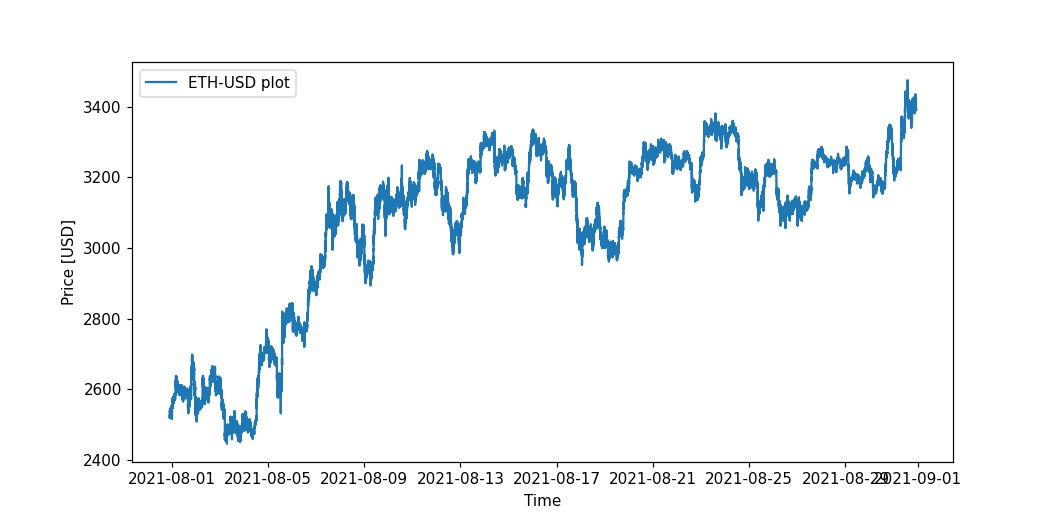

In [17]:
# simple plot
fig, axes = plt.subplots()
fig = plt.plot(ETHUSD['price']) # pandas uses index on x-axis by default
plt.legend(['ETH-USD plot'])
plt.xlabel('Time')
plt.ylabel('Price [USD]')
plt.show()

## 3.1 Occurences of price difference

Because we have three time series and want to plot the *difference*, we need to merge or align them. 
This is done by taking the ETHUSD data (as it has the most trades) and for each trade, find the closest (looking backwards) ETH-EUR price and merge that with the closest EUR-USD price.

In [63]:
# merge ETHUSD and ETHEUR
ETH_USD_EUR = pd.merge_asof(ETHUSD[['price']], ETHEUR[['price']], on='time', suffixes=('_USD', '_EUR'))

# and merge again with EURUSD
df = pd.merge_asof(ETH_USD_EUR, EURUSD[['price']], on='time')

df.rename(columns={'price': 'price_EURUSD'}, inplace=True)

df['price_USD_from_EURUSD'] = df['price_EUR']*df['price_EURUSD']

df['price_diff'] = df['price_USD'] - df['price_USD_from_EURUSD']

df['price_diff_percent'] = (df['price_diff'] / df['price_USD'])*100

df = df.set_index('time')

<IPython.core.display.Javascript object>


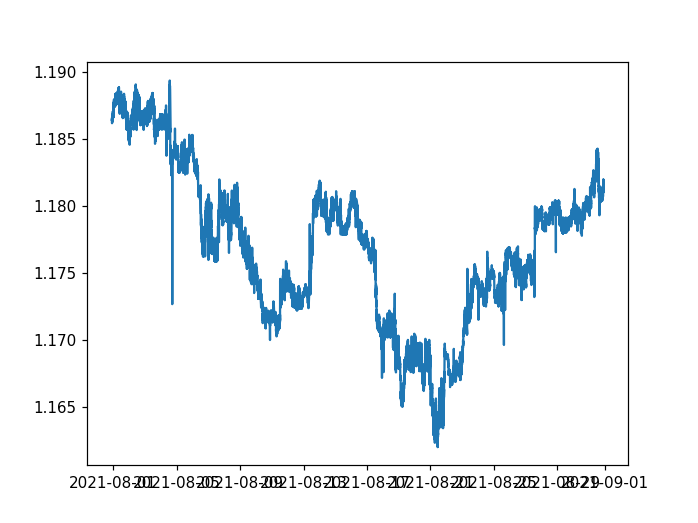

In [30]:
fig, axes = plt.subplots()
fig = plt.plot(EURUSD['price'])
plt.show()

<IPython.core.display.Javascript object>


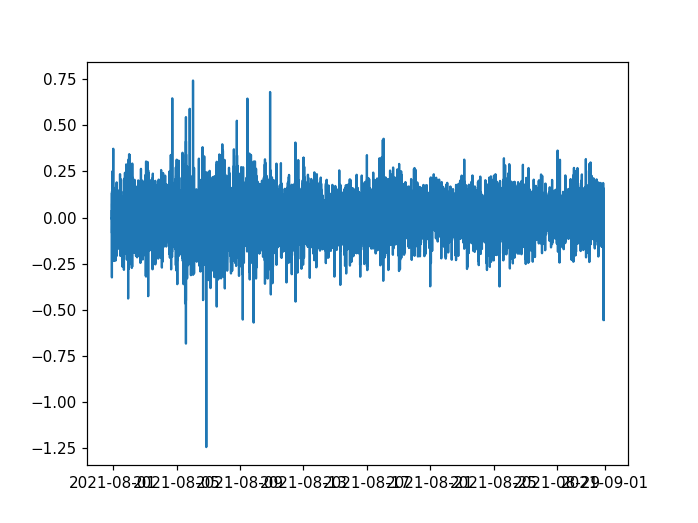

In [64]:
fig, axes = plt.subplots()
fig = plt.plot(df['price_diff_percent'])
plt.show()

<IPython.core.display.Javascript object>


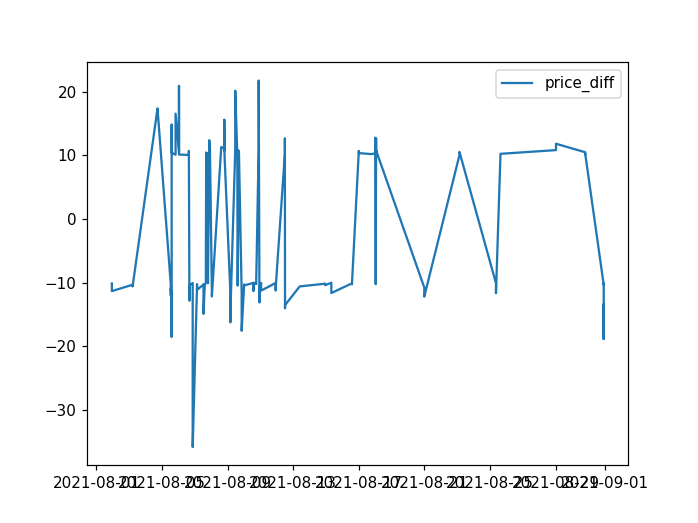

In [58]:
df_cutoff = df.loc[df['price_diff'] > 10].append(df.loc[df['price_diff'] < -10]).sort_index()
df_cutoff

fig, axes = plt.subplots()
fig = plt.plot(df_cutoff['price_diff'])
plt.legend(["price_diff"])
plt.show()

## 3.2 Duration of difference

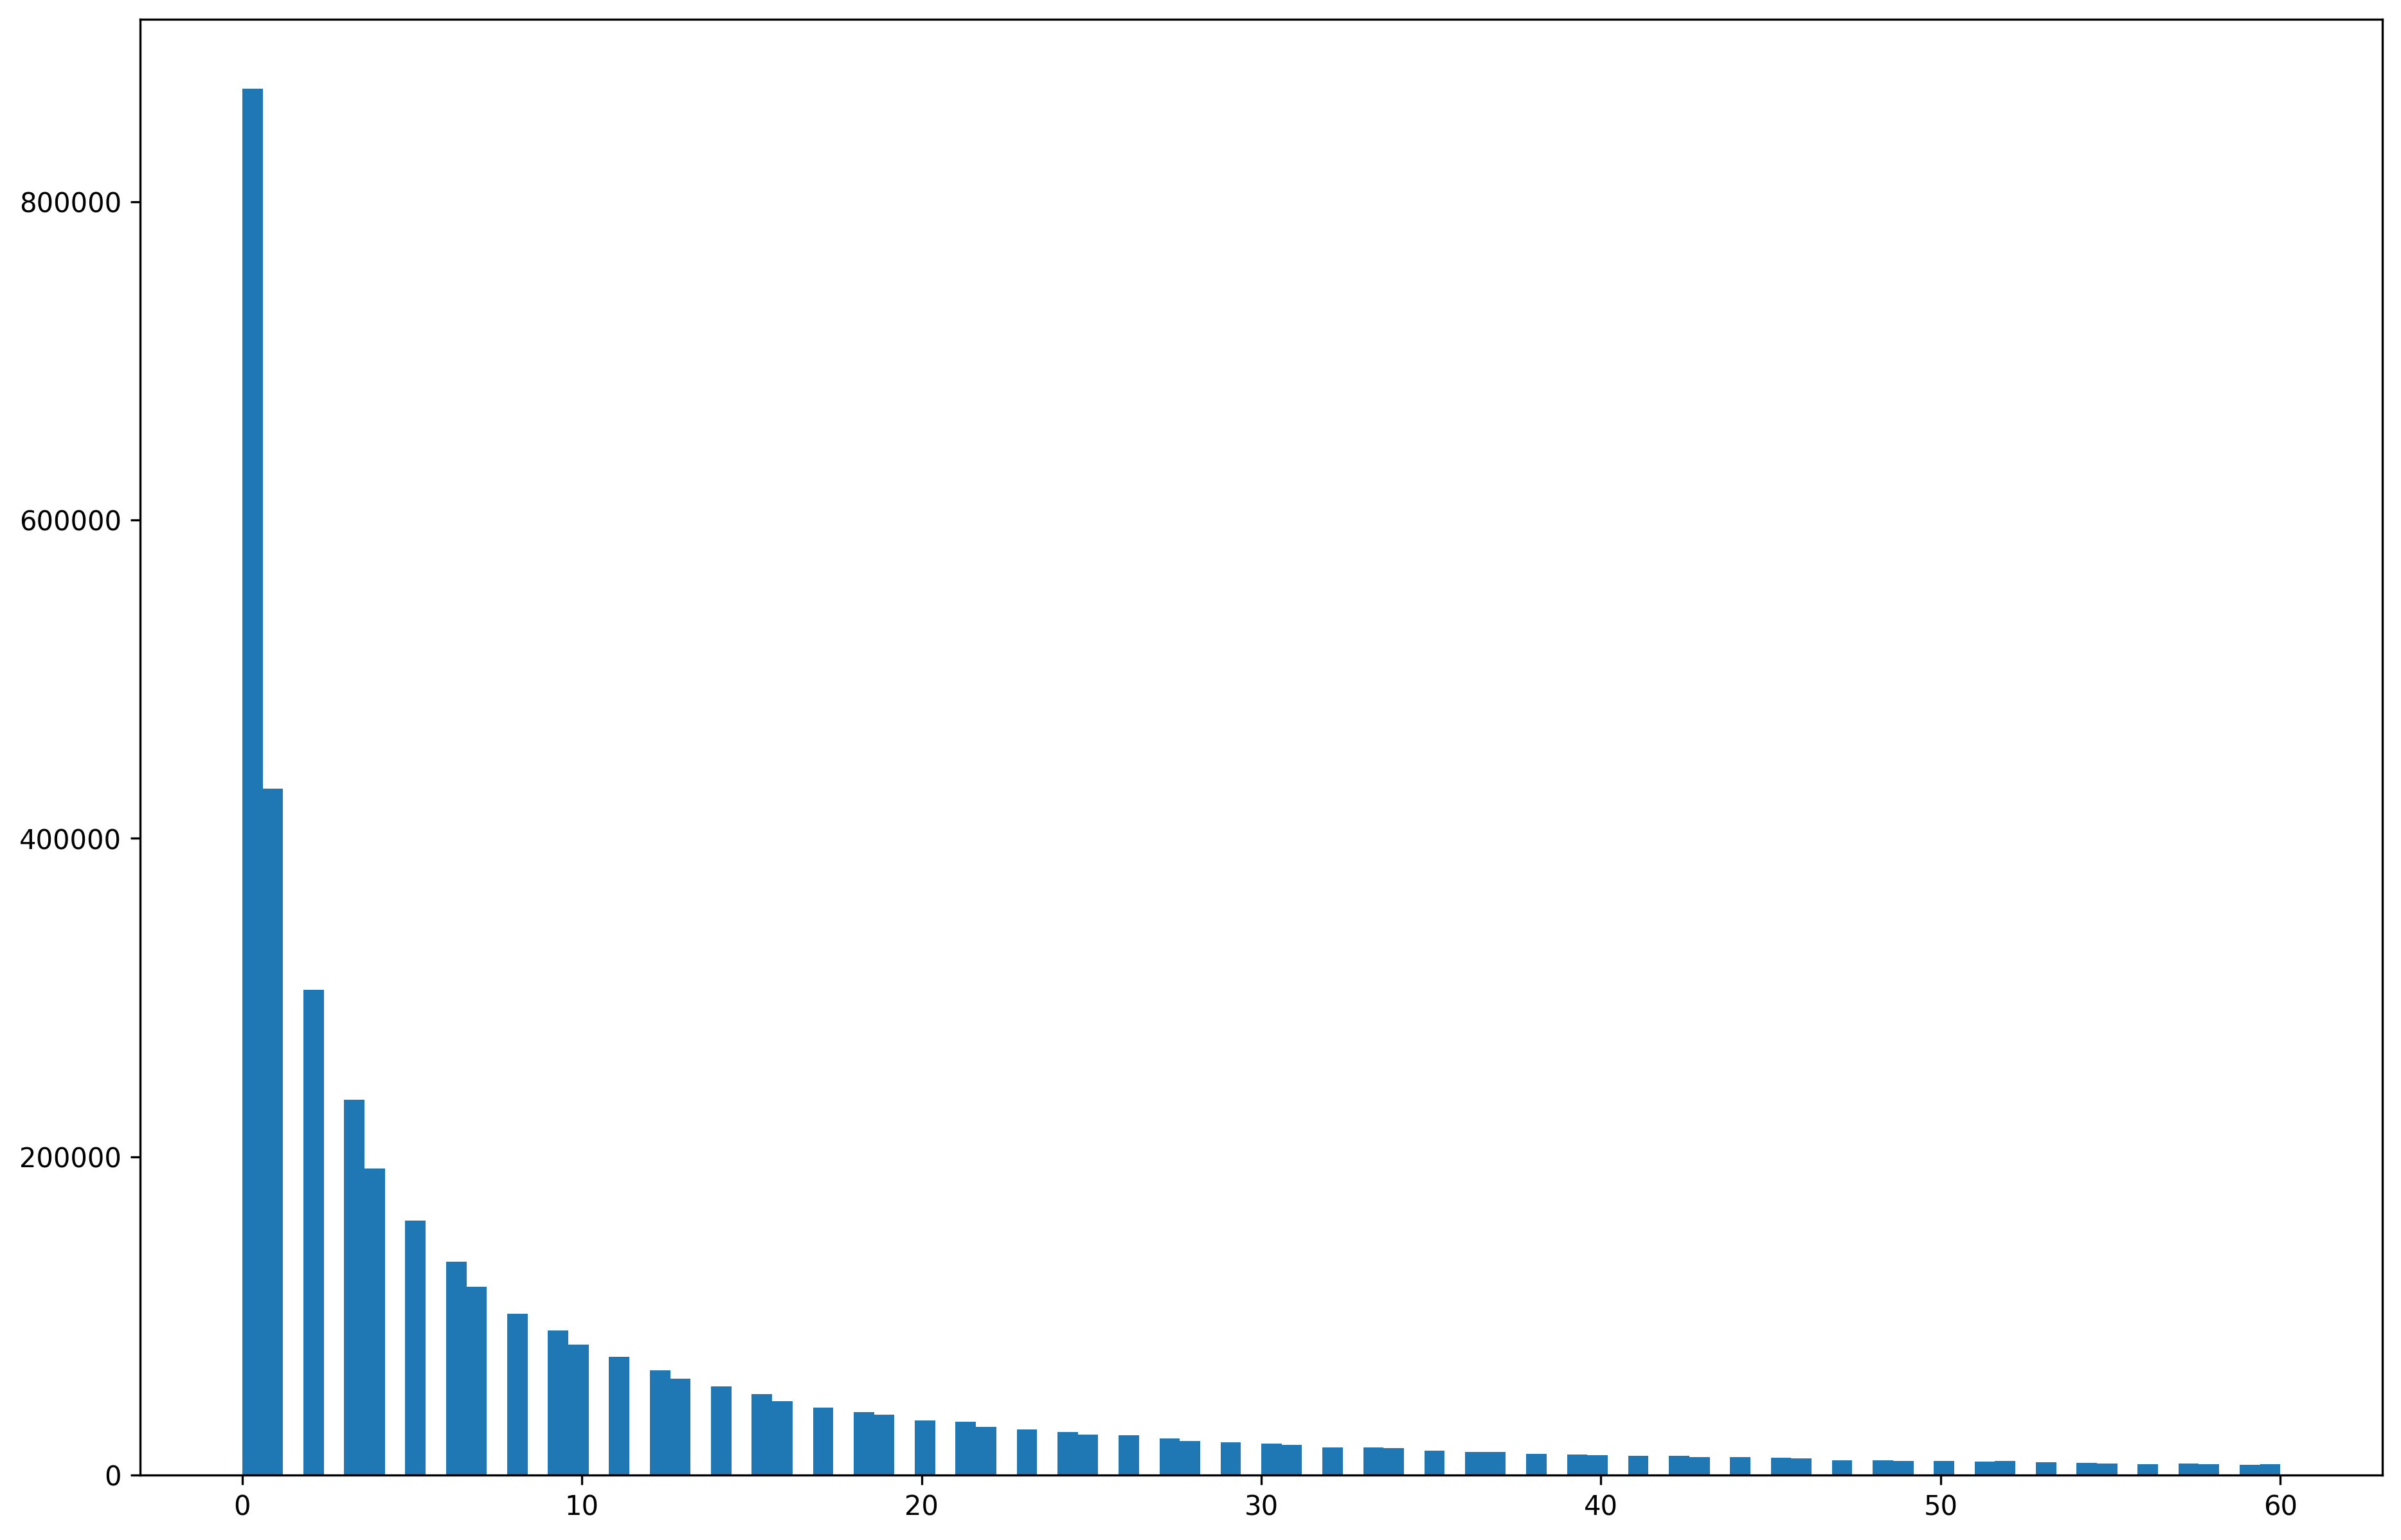

In [9]:
plt.hist(ETHUSD['price_EUR_time_delta'].astype('timedelta64[s]'), 100, (0, 60))
plt.show()

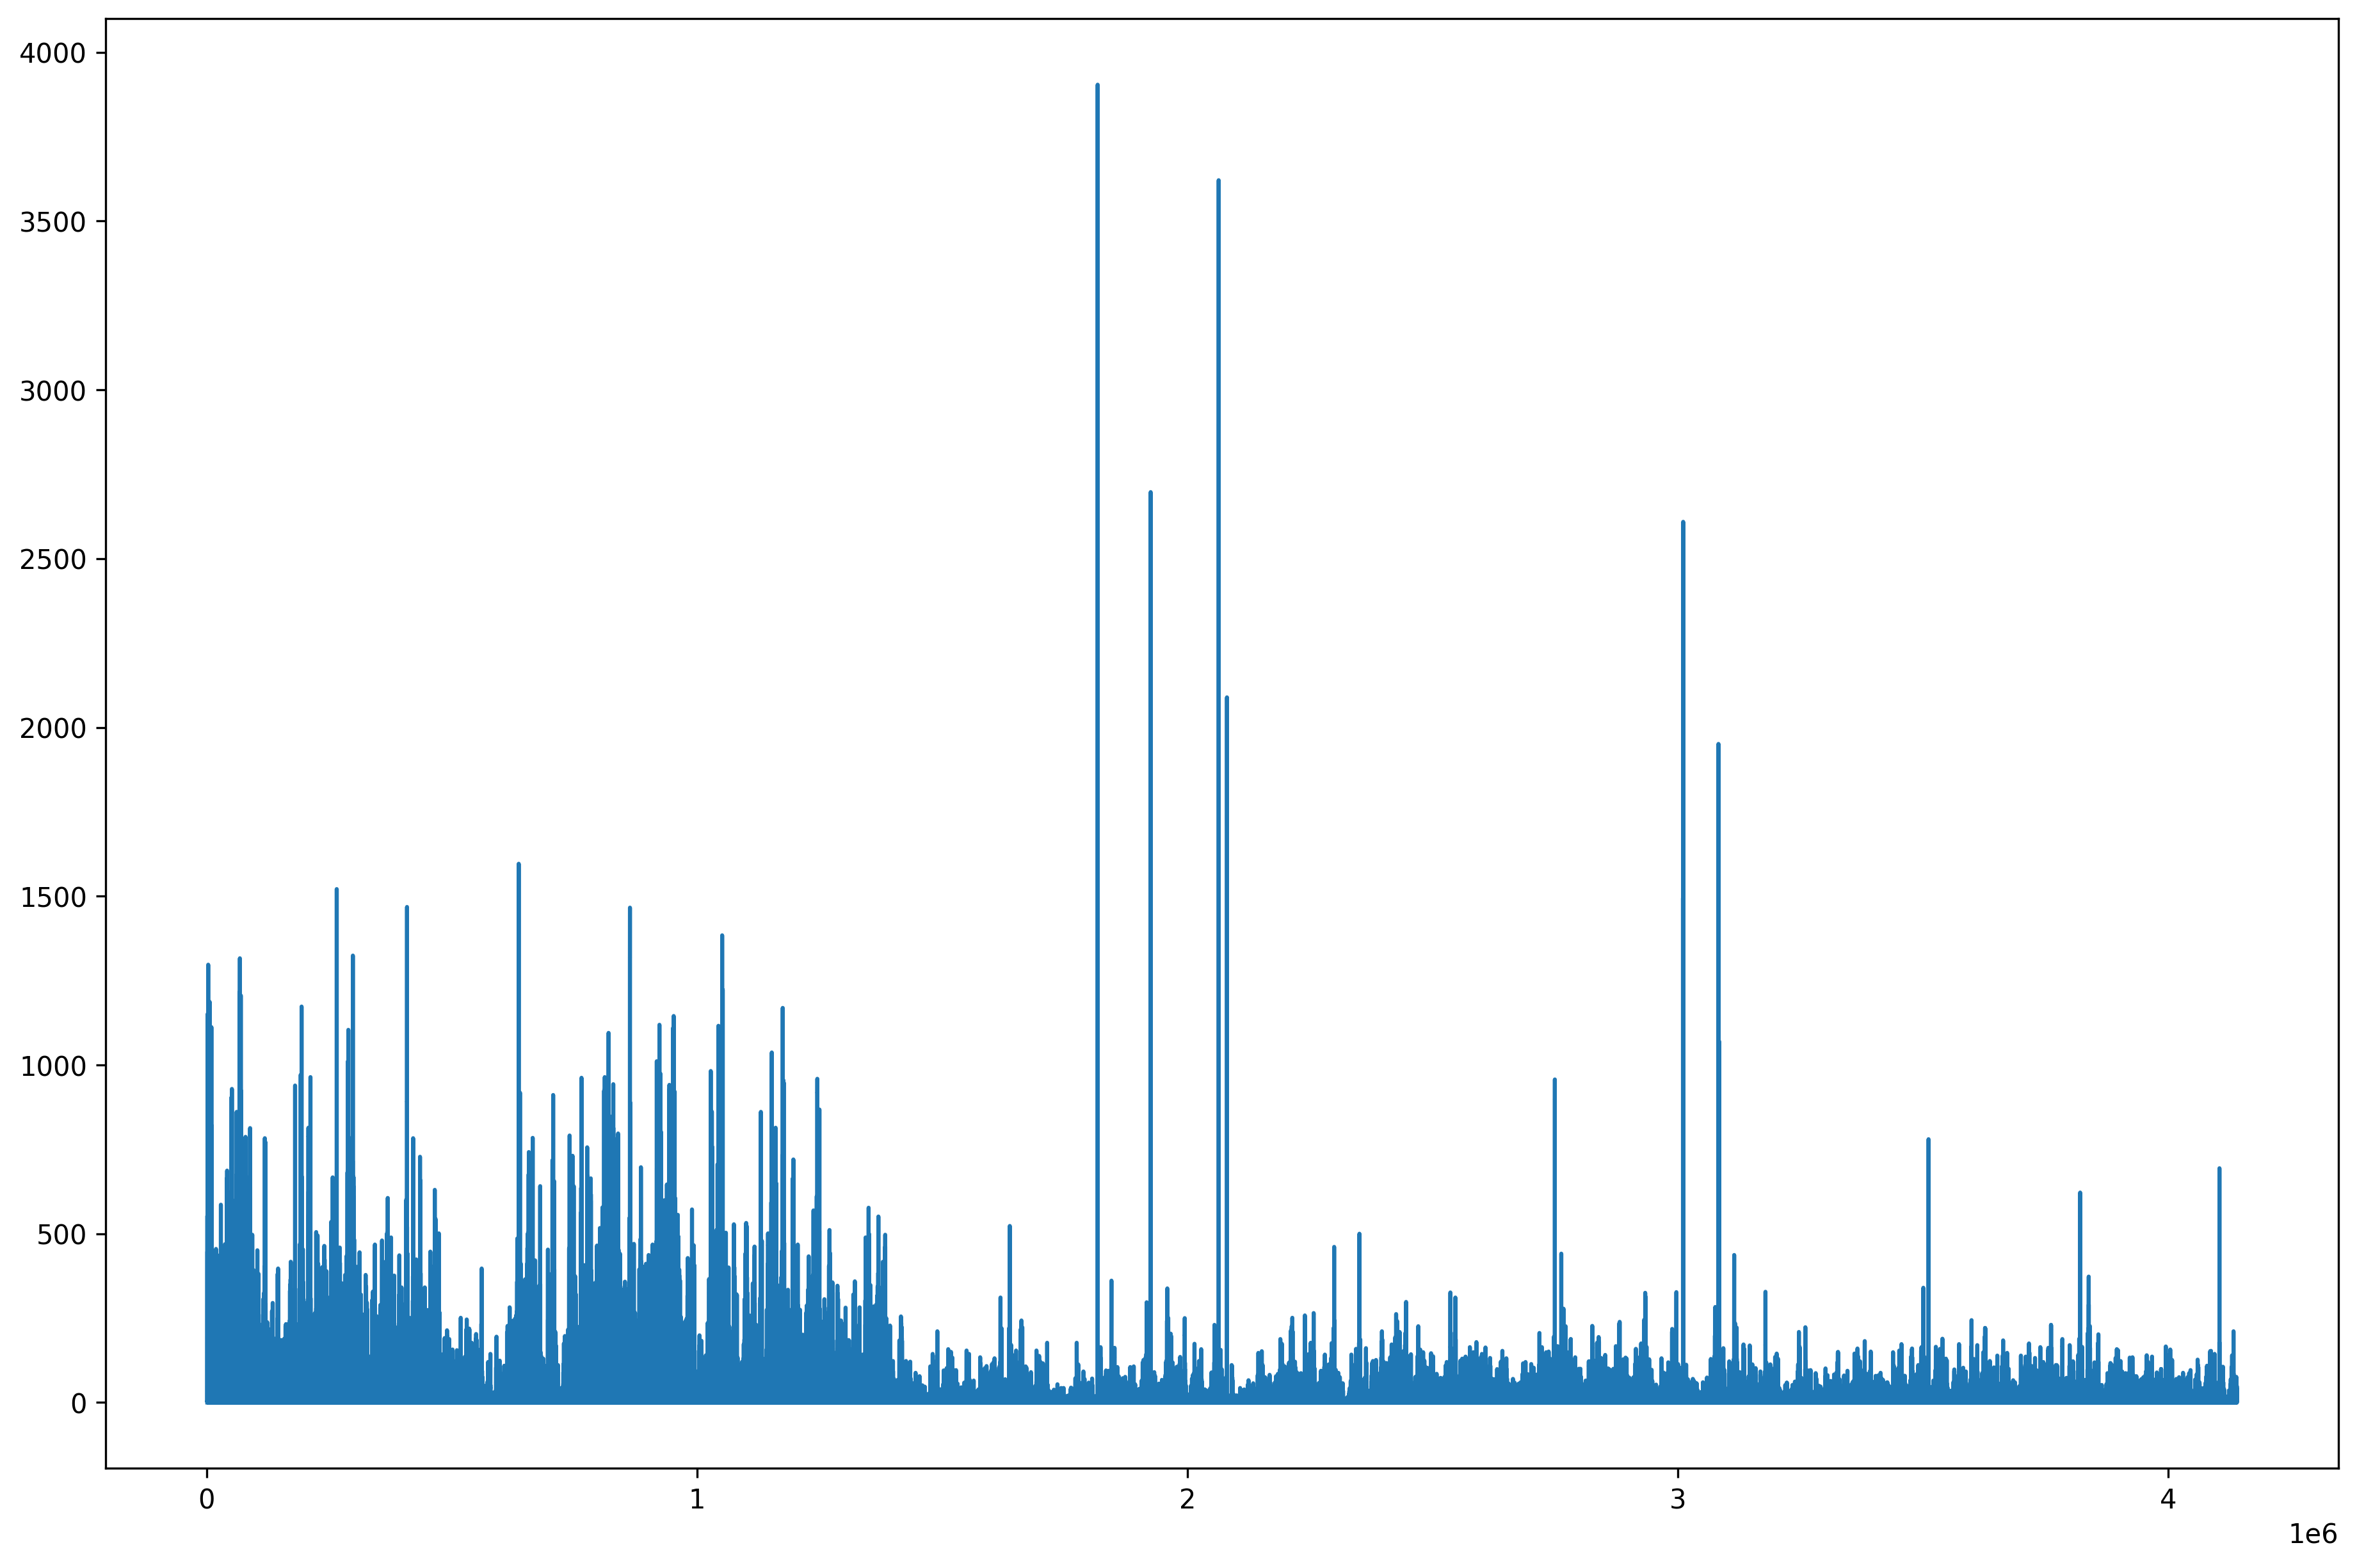

In [10]:
plt.plot(ETHUSD['price_EUR_time_delta'].astype('timedelta64[s]'))

## 3.3 Statistical measures of differences

In [20]:
print(np.mean(ETHUSD['price_EUR_time_delta'].astype('timedelta64[s]'))) # simple average
print(np.average(ETHUSD['price_EUR_time_delta'].astype('timedelta64[ms]'))) # weighted average
print(np.std(ETHUSD['price_EUR_time_delta'].astype('timedelta64[s]'))) # standard deviation

19.930998920363
nan
56.01206287950998


In [11]:
# start capital
NUSD = 1000.0
NEUR = 1000.0

# fees, 0.26%
fee = 0.0026



In [ ]:
ETHUSD['price_delta'] = ETHUSD['price_EUR'] - ETHUSD['price_latest_EUR']
ETHUSD['price_delta_percent'] = (ETHUSD['price_delta'] / ETHUSD['price_EUR'])*100.0
ETHUSD

# 4. Live demo using WebSockets

In [ ]:
import json, time, datetime, sys, numpy as np
from websocket import create_connection

try:
    ws = create_connection("wss://ws.kraken.com")
    ws_book = create_connection("wss://ws.kraken.com")
except Exception as error:
    print('Caught this error: ' + repr(error))
    
pairs = ["ETH/USD", "ETH/EUR", "EUR/USD"]

ticker_dict = {
    "event": "subscribe",
    "pair": pairs,
    "subscription": {"name": "ticker"}
}

book_dict_ETHUSD = {
    "event": "subscribe",
    "pair": ["ETH/USD"],
    "subscription": {"name": "book", "depth": 100}
}
                                
book_dict_ETHEUR = {
    "event": "subscribe",
    "pair": ["ETH/EUR"],
    "subscription": {"name": "book", "depth": 100}
}                              


# send request for ticker
ws.send(json.dumps(ticker_dict))

# get (useless) first response
result = ws.recv()

ids = {}

# get channelIDs
for pair in pairs:
    result = ws.recv()
    result = json.loads(result)
    ids[pair] = result['channelID']

#print(result['channelID'])

print(ids)

# initializing these 
ETHUSD = None
ETHEUR = None
EURUSD = None

# limit on when to do arb
delta_limit = 1.0

# to avoid "overshooting" when arbing
slip = 0.9

while True:
    try:

        result = ws.recv()
        result = json.loads(result)
        
        # only go on if response is not the heartbeat
        if type(result) is not dict:
            
            id = result[-1]
            val = result[1]['c'][0]
            now = datetime.datetime.now()
            
            if id == "ETH/USD":
                ETHUSD = float(val)
            
            elif id == "ETH/EUR":
                ETHEUR = float(val)
            
            elif id == "EUR/USD":
                EURUSD = float(val)                
            
            if None not in (ETHUSD, ETHEUR, EURUSD):
                
                ETHUSD_EUR = ETHUSD*(1.0/EURUSD)
                delta = ETHUSD_EUR - ETHEUR
                
                
                #print(ETHUSD, ETHUSD_EUR, ETHEUR)

                #print(delta)

                # EUR -> ETH -> USD
                if delta > delta_limit:

                    # send request for book
                    ws_book.send(json.dumps(book_dict_ETHEUR))

                    while True:
                        try:
                            result_book = ws_book.recv()
                            result_book = json.loads(result_book)
                            ETHEUR_book_as = result_book[1]['as']

                            #print(ETHEUR_book_as)
                            
                            vol = order_scan(ETHEUR_book_as, ETHEUR + delta*slip)
                            
                            print("Delta = {0}, Buy {1} ETHEUR at {2} and sell at {3} ETHUSD".format(delta, vol, ETHEUR, ETHUSD))
                            
                            break
                        except KeyError:
                            continue
                            
                    
                            
                    # useless first and second response
                    #result_book = ws_book.recv()
                    #result_book = ws_book.recv()
                    #result_book = ws_book.recv()

                    #result_book = json.loads(result_book)
                                        
                    #if type(result_book) is not dict:
                    
                        #print(result_book)

                    
                        #ETHEUR_book_as = result_book[1]['as']

                        #print(ETHEUR_book_as)


                # USD -> ETH -> EUR
                #if delta < -delta_limit

                    
        
            
        #print("Received {0} at {1}".format(result, datetime.datetime.now()))
    except Exception as error:
        print('Caught this error: ' + repr(error))
        time.sleep(3)

ws.close()

In [ ]:
def order_scan(book: list, target: float) -> float:
    
    vol = 0.0
    
    for item in book:
        
        price = float(item[0])
        volume = float(item[1])
        
        if price < target:
            vol += volume
            
        elif price >= target:
            return vol
            

## 5. Appendix: download Kraken data

Below is the program (identical to the `get_data.py` program) used to download historical trades from Kraken's REST API. The example fetches ETH-USD data from March 1st to September 1st and saves the data as a csv-file.

Note the use of type hints require `python 3.9` or newer. 

In [1]:
#!/usr/bin/env python3

import requests
import json
import csv
import datetime as dt
import time
import pandas as pd

# unix timestamps
start = 1614553200 # 20210301 2021 march 1st
end = 1614853200

#end = 1631484000 # 20210901 2021 september 1st

pair_name = "ETHEUR"

# general format of ticker_name on Kraken is "X<crypto>Z<fiat>"
ticker_name="XETHZEUR"

def download_batch(start: int) -> tuple[list[list], int]:
    """ 
    Download a batch of trades (which is 1000 trades) from the Kraken API (https://docs.kraken.com/rest/) 
    and return the data plus the timestamp of the last downloaded trade
    """

    response = requests.get(f'https://api.kraken.com/0/public/Trades?pair={pair_name}&since={start}')

    # convert to JSON
    res = response.json()

    batch: list[list] = res['result'][ticker_name]

    # remove useless last empty column
    for i in batch:
        i.pop()

    # set end time to timestamp of last trade in batch
    end: int = batch[-1][2]

    return (batch, end)


def download_all(start: int, end: int) -> list[list]:
    """
    Given start and end, download all data for a given pair as defined in the top
    """

    data = []

    # get first batch end (start of new)
    batch, start = download_batch(start)

    # we use extend() instead of append() as the batch is a list
    data.extend(batch)

    # main while loop
    while start <= end:

        start_dt = dt.datetime.fromtimestamp(start).isoformat()

        print(start_dt)

        batch, batch_end = download_batch(start)

        if start == batch_end:
            # this is the case of multiple trades occuring at the exact time on the last trade of the batch, 
            # so we add a single millisecond
            start = batch_end + 1
        else:
            start = batch_end

        data.extend(batch)

        # wait 3500 ms as not to overload Kraken's API
        time.sleep(3.5)

    return data


def write_data():
    """
    Write the downloaded data to a csv-file
    """

    data = download_all(start, end)
    
    # add header
    header = ['price','size','time','side','type']
    
    # we are lazy and use Pandas to remove duplicate rows.
    df = pd.DataFrame(data, columns = header)
    
    df = df.drop_duplicates()
    
    # reorder columns for convenience
    df = df[['time', 'size', 'price', 'side' ,'type']]
    
    # save to csv (with no indes)
    # also restricting float format to 5 decimals as that is the accuracy of the source
    df.to_csv(f"{pair_name}_uniq_test.csv", index = False, float_format="%.5f")


write_data()




TypeError: 'type' object is not subscriptable

In [2]:
import sys
sys.executable

'/usr/local/opt/python@3.8/bin/python3.8'